# 2 Dimensional Histograms

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
import statsmodels.stats.multitest

import matplotlib.ticker as ticker

import cptac
import cptac.utils as u

# Step 1: Get Data Frame and Calculate Std Dev and Mean

Download data frame that has FDR corrected pvalues for all trans proteins. Next, calculate the total number of p values significant for each trans protein. Then calculate the mean and standard deviation of pvalues/ difference in medians across a trans gene. 

In [2]:
root = R'~\Github\WhenMutationsDontMatter\PTEN\Step_3_trans_effect\csv'
df_fdr_pvals = pd.read_csv(root+R"\all_pval_all_proteins.csv")
df_fdr_pvals = df_fdr_pvals.loc[df_fdr_pvals['Proteomics'] != 'PTEN'] # Drop PTEN

# Drop Kidney
cols = []
df_fdr_pvals = df_fdr_pvals.drop(cols)
df_fdr_pvals
len(df_fdr_pvals)


15097

In [3]:

def Pvalue_sig(row):
    numSig = 0

    for item in row:
        if pd.isnull(item):
            continue
        if item < 0.05: # changed from .1????
            numSig += 1
            
    return numSig

In [4]:
#Only include genes that have data for at least 6/8 genes.
df_fdr_pvals = df_fdr_pvals.dropna(thresh=12, axis=0)

In [5]:
df_fdr_pvals["Num_sig"] = df_fdr_pvals.loc[:,["Gbm_P_Value","Hnscc_P_Value","Luad_P_Value","Lscc_P_Value", "Brca_P_Value","Ov_P_Value","En_P_Value","Colon_P_Value"]].apply(Pvalue_sig, axis = 1)
df_fdr_pvals = df_fdr_pvals.sort_values(by=['Num_sig'],ascending=False)
df_fdr_pvals

,Proteomics,Gbm_P_Value,Gbm_Median,Hnscc_P_Value,Hnscc_Median,Luad_P_Value,Luad_Median,Lscc_P_Value,Lscc_Median,Brca_P_Value,Brca_Median,Ov_P_Value,Ov_Median,En_P_Value,En_Median,Colon_P_Value,Colon_Median,Num_sig
1132,RIF1,0.021298,0.360544,0.038812,0.468772,0.999320,0.23970,0.999848,0.13570,0.723699,0.28535,0.985704,0.117336,0.001590,-0.54640,0.953484,-0.1135,3
271,SLK,0.003506,-0.305757,0.005300,-0.443020,0.043043,-0.52600,0.083806,-0.61615,0.375369,-0.51380,0.985704,-0.122267,0.074890,0.40530,0.624087,-0.1814,3
650,NUF2,0.009780,0.999942,0.023883,0.672025,0.569117,1.69920,0.999848,0.13015,0.487632,0.42865,0.997950,-0.079618,0.034789,-0.61250,NaN,NaN,3
1439,TPX2,0.031690,0.640139,0.039944,0.490643,0.778198,0.18745,0.999848,-0.10280,0.462570,-0.05995,0.985704,0.216007,0.021371,-0.80000,0.963829,-0.0305,3
1856,PTPRC,0.048137,-0.715419,0.011761,-0.759050,0.039512,-1.23705,0.999848,0.25000,0.925261,-0.17745,0.985704,0.127666,0.556641,-0.23800,0.926083,-0.0099,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5128,SLC4A1,0.302024,-0.404558,0.585275,-0.302099,0.724646,-0.39875,0.999848,0.16660,0.443309,-1.10290,0.991374,-0.597169,0.842187,0.38100,0.868297,0.2830,0
5127,SERPIND1,0.301334,-0.464742,0.316514,-0.307279,0.318870,-0.49895,0.999848,-0.05520,0.493399,-0.48955,0.985704,0.205481,0.435570,0.17900,0.987216,0.0090,0
5126,EMC2,0.301334,0.121113,0.348623,0.060871,0.461915,0.29065,0.999848,0.11970,0.767521,0.28710,0.985704,0.066198,0.923632,-0.00180,0.854580,-0.0946,0
5123,PC,0.301295,-0.301898,0.467900,0.001199,0.301530,1.43660,0.999848,-0.92235,0.897763,-0.00830,0.985704,0.218755,0.907455,0.06344,0.917530,-0.0725,0


In [6]:
#Calculate mean and standard deviation for pvalues and Pearson Correlations
df_fdr_pvals["Standard_Deviation_P_value"] = df_fdr_pvals.loc[:,["Gbm_P_Value","Hnscc_P_Value","Luad_P_Value","Lscc_P_Value", "Brca_P_Value","Ov_P_Value","En_P_Value","Colon_P_Value"]].std(axis = 1)
df_fdr_pvals["Mean_P_value"] = df_fdr_pvals.loc[:,["Gbm_P_Value","Hnscc_P_Value","Luad_P_Value","Lscc_P_Value", "Brca_P_Value","Ov_P_Value","En_P_Value","Colon_P_Value"]].mean(axis = 1)
df_fdr_pvals["Standard_Deviation_Change_In_Medians"] = (df_fdr_pvals.loc[:,["Gbm_Median","Hnscc_Median","Luad_Median","Lscc_Median", "Brca_Median","Ov_Median","En_Median","Colon_Median"]].std(axis = 1))
df_fdr_pvals["Mean_Change_In_Medians"] = (df_fdr_pvals.loc[:,["Gbm_Median","Hnscc_Median","Luad_Median","Lscc_Median", "Brca_Median","Ov_Median","En_Median","Colon_Median"]].mean(axis = 1))



In [7]:
df_fdr_pvals.loc[df_fdr_pvals['Proteomics'] == 'MCM2']

,Proteomics,Gbm_P_Value,Gbm_Median,Hnscc_P_Value,Hnscc_Median,Luad_P_Value,Luad_Median,Lscc_P_Value,Lscc_Median,Brca_P_Value,...,Ov_Median,En_P_Value,En_Median,Colon_P_Value,Colon_Median,Num_sig,Standard_Deviation_P_value,Mean_P_value,Standard_Deviation_Change_In_Medians,Mean_Change_In_Medians
198,MCM2,0.002222,0.939513,0.031644,0.470941,0.589499,1.2664,0.999848,0.01375,0.571025,...,-0.023866,0.093409,-0.611,0.987641,-0.08845,2,0.440867,0.532624,0.604549,0.300455


In [8]:
#Keep trans genes that are significant in atleast 1 cancer. 

df_fdr_pvals_1 = df_fdr_pvals[df_fdr_pvals['Num_sig'].isin([1,2,3,4,5,6,7,8])]
len(df_fdr_pvals_1.Proteomics.unique())

2333

# Step 2: Plot 2D Histogram

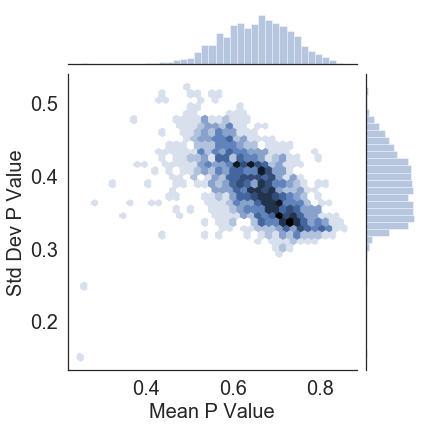

In [9]:

sns.set(rc={'xtick.labelsize':20,
            'ytick.labelsize':20}, style = "white")
g = (sns.jointplot("Mean_P_value","Standard_Deviation_P_value",data = df_fdr_pvals_1, kind="hex", bins = 10)
        .set_axis_labels("Mean P Value", "Std Dev P Value", fontsize=20))
#g.ax_marg_x.set_xlim(-0.1, 1)
plt.show()
g.savefig("PTEN_Fig_1C_Pvalue_sig_atleast1_cancer.png", dpi = 300)

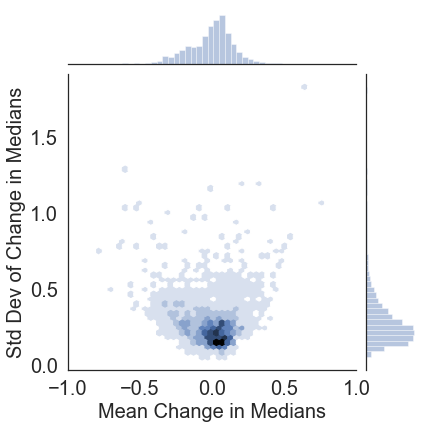

In [10]:
sns.set(rc={'xtick.labelsize':20,
            'ytick.labelsize':20}, style = "white")

g = (sns.jointplot("Mean_Change_In_Medians","Standard_Deviation_Change_In_Medians",data = df_fdr_pvals_1, kind="hex", bins = 10)
        .set_axis_labels("Mean Change in Medians", "Std Dev of Change in Medians", fontsize=20))

g.ax_marg_x.set_xlim(-1, 1)
#g.ax_marg_y.set_ylim(0, 1)

g.savefig("PTEN_Fig_1C_medians_atleast1_cancer.png", dpi = 300)
plt.show()

# Filter for genes significant in at least 2 Cancers 

In [14]:

df_fdr_pvals_2 = df_fdr_pvals[df_fdr_pvals['Num_sig'].isin([2,3,4,5,6,7,8])]
len(df_fdr_pvals_2)

326

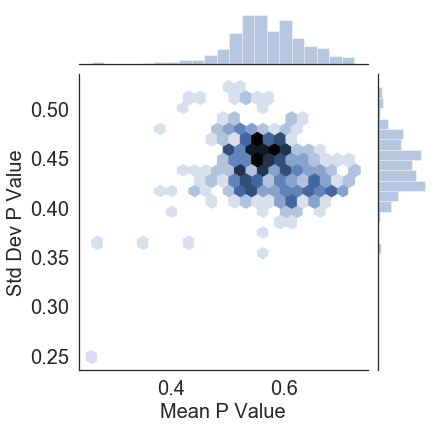

In [12]:

sns.set(rc={'xtick.labelsize':20,
            'ytick.labelsize':20}, style = "white")
g = (sns.jointplot("Mean_P_value","Standard_Deviation_P_value",data = df_fdr_pvals_2, kind="hex", bins = 10)
        .set_axis_labels("Mean P Value", "Std Dev P Value", fontsize=20))

plt.show()
g.savefig("EGFR_Fig_1C_Pvalue_atleast2_cancers.png", dpi = 300)

ValueError: Could not interpret input 'Mean_Correlation'

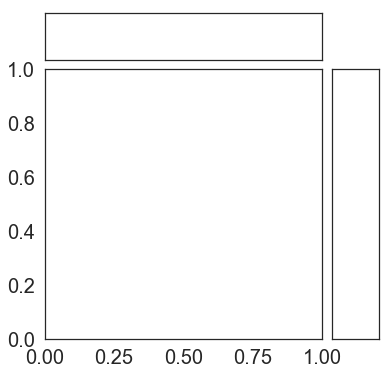

In [13]:
sns.set(rc={'xtick.labelsize':20,
            'ytick.labelsize':20}, style = "white")

g = (sns.jointplot("Mean_Correlation","Standard_Deviation_Correlation",data = df_fdr_pvals_2, kind="hex", bins = 10)
        .set_axis_labels("Mean Correlaiton", "Std Dev Correlation", fontsize=20))


g.savefig("EGFR_Fig_1C_Corr_atleast2_cancers.png", dpi = 300)
plt.show()

# At least 3 Cancers

In [ ]:

df_fdr_pvals_3 = df_fdr_pvals[df_fdr_pvals['Num_sig'].isin([3,4,5,6,7,8])]

In [ ]:

sns.set(rc={'xtick.labelsize':20,
            'ytick.labelsize':20}, style = "white")
g = (sns.jointplot("Mean_P_value","Standard_Deviation_P_value",data = df_fdr_pvals_3, kind="hex", bins = 10)
        .set_axis_labels("Mean P Value", "Std Dev P Value", fontsize=20))

plt.show()
g.savefig("EGFR_Fig_1C_Pvalue_EGFR_atleast3_cancers.png", dpi = 300)

In [ ]:
sns.set(rc={'xtick.labelsize':20,
            'ytick.labelsize':20}, style = "white")

g = (sns.jointplot("Mean_Correlation","Standard_Deviation_Correlation",data = df_fdr_pvals_3, kind="hex", bins = 10)
        .set_axis_labels("Mean Correlaiton", "Std Dev Correlation", fontsize=20))


g.savefig("EGFR_Fig_1C_Corr_EGFR_atleast3_cancers.png", dpi = 300)
plt.show()

# Atleast 4

In [ ]:

df_fdr_pvals_4 = df_fdr_pvals[df_fdr_pvals['Num_sig'].isin([4,5,6,7,8])]

In [ ]:

sns.set(rc={'xtick.labelsize':20,
            'ytick.labelsize':20}, style = "white")
g = (sns.jointplot("Mean_P_value","Standard_Deviation_P_value",data = df_fdr_pvals_4, kind="hex", bins = 10)
        .set_axis_labels("Mean P Value", "Std Dev P Value", fontsize=20))

plt.show()
g.savefig("EGFR_Fig_1C_Pvalue_EGFR_atleast4_cancers.png", dpi = 300)

In [ ]:
sns.set(rc={'xtick.labelsize':20,
            'ytick.labelsize':20}, style = "white")

g = (sns.jointplot("Mean_Correlation","Standard_Deviation_Correlation",data = df_fdr_pvals_4, kind="hex", bins = 10)
        .set_axis_labels("Mean Correlaiton", "Std Dev Correlation", fontsize=20))


g.savefig("EGFR_Fig_1C_Corr_atleast4_cancers.png", dpi = 300)
plt.show()

In [ ]:
df_fdr_pvals_1

In [ ]:
prot_genes_list = df_fdr_pvals_1.index.to_list()

In [ ]:
def anydup(thelist):
    seen = set()
    for x in thelist:
        if x in seen: return True
        seen.add(x)
    return False

In [ ]:
anydup(prot_genes_list)

In [ ]:
df_fdr_pvals_1['Num_sig'].value_counts()